In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet50
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 42
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

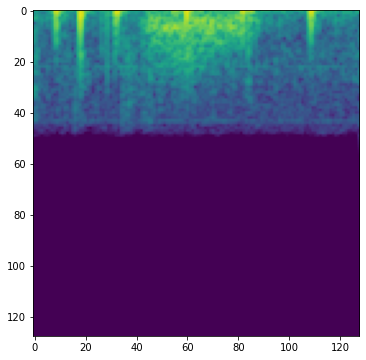

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet50

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
0.7605899358382766
TEST
loss: 0.6157615441178519
accuracy: 0.7904761904761904
******************
epoch: 1
Train
0.571913966022852
TEST
loss: 0.659733545117908
accuracy: 0.7492063492063492
******************
epoch: 2
Train
0.4876987794214435
TEST
loss: 0.64067289630572
accuracy: 0.8031746031746032
******************
epoch: 3
Train
0.48115701255010557
TEST
loss: 0.6398924398989905
accuracy: 0.7619047619047619
******************
epoch: 4
Train
0.4813684955109103
TEST
loss: 0.8092487448737735
accuracy: 0.780952380952381
******************
epoch: 5
Train
0.43097181169640175
TEST
loss: 0.552923118595093
accuracy: 0.780952380952381
******************
epoch: 6
Train
0.35559760070775026
TEST
loss: 0.998218293984731
accuracy: 0.7587301587301587
******************
epoch: 7
Train
0.35220315874901154
TEST
loss: 0.60614334884144
accuracy: 0.7873015873015873
******************
epoch: 8
Train
0.30671820300168895
TEST
loss: 0.9950800076363578
accuracy: 0.5968253968253968
****************

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8274111675126904


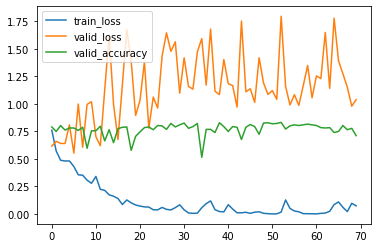

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.771602080964777
TEST
loss: 0.6859035143776545
accuracy: 0.7682539682539683
******************
epoch: 1
Train
0.6118129556665731
TEST
loss: 0.566463148499292
accuracy: 0.8031746031746032
******************
epoch: 2
Train
0.5708435820718906
TEST
loss: 0.7319601690012311
accuracy: 0.765079365079365
******************
epoch: 3
Train
0.5340993880657472
TEST
loss: 0.5799667786984216
accuracy: 0.7841269841269841
******************
epoch: 4
Train
0.5748714648417956
TEST
loss: 1.1007902289193774
accuracy: 0.746031746031746
******************
epoch: 5
Train
0.5775809878863637
TEST
loss: 0.5833030888958582
accuracy: 0.7904761904761904
******************
epoch: 6
Train
0.47073920758779886
TEST
loss: 0.6783798357797047
accuracy: 0.8
******************
epoch: 7
Train
0.4420676686112326
TEST
loss: 0.5342282864782545
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.42703788412100174
TEST
loss: 0.8515999992688497
accuracy: 0.615873015873015

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8274111675126904


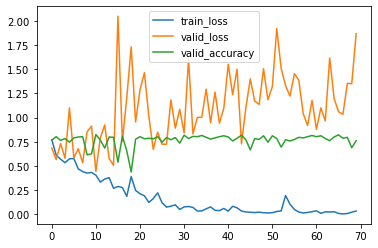

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8385575989392942
TEST
loss: 1.0725240887157501
accuracy: 0.6761904761904762
******************
epoch: 1
Train
0.6506457353888095
TEST
loss: 0.6833076381494129
accuracy: 0.7904761904761904
******************
epoch: 2
Train
0.5736698348717238
TEST
loss: 0.5327318314522032
accuracy: 0.8095238095238095
******************
epoch: 3
Train
0.5344812628222042
TEST
loss: 1.739554848746648
accuracy: 0.40634920634920635
******************
epoch: 4
Train
0.5139118092840299
TEST
loss: 0.5199085086111038
accuracy: 0.8158730158730159
******************
epoch: 5
Train
0.4647156364203825
TEST
loss: 0.5989689108871278
accuracy: 0.7841269841269841
******************
epoch: 6
Train
0.41407646767860185
TEST
loss: 0.5877100546208639
accuracy: 0.7523809523809524
******************
epoch: 7
Train
0.4207480745811705
TEST
loss: 0.7033670800072807
accuracy: 0.726984126984127
******************
epoch: 8
Train
0.4341817245396288
TEST
loss: 0.6090072834302509
accuracy: 

In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.799492385786802


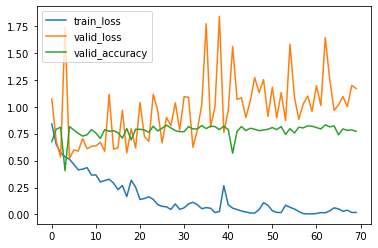

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7599068082354199
TEST
loss: 0.814934342058878
accuracy: 0.7428571428571429
******************
epoch: 1
Train
0.5832694651732092
TEST
loss: 1.7208534115836733
accuracy: 0.5079365079365079
******************
epoch: 2
Train
0.5184222820782302
TEST
loss: 0.5347144630220201
accuracy: 0.8126984126984127
******************
epoch: 3
Train
0.5274473280069656
TEST
loss: 0.6266452306792849
accuracy: 0.7746031746031746
******************
epoch: 4
Train
0.49452019343781417
TEST
loss: 0.8215716338346875
accuracy: 0.7873015873015873
******************
epoch: 5
Train
0.39422178855483925
TEST
loss: 0.8660899609800369
accuracy: 0.6825396825396826
******************
epoch: 6
Train
0.38252384560604336
TEST
loss: 0.6071045888794793
accuracy: 0.8126984126984127
******************
epoch: 7
Train
0.37782101843260507
TEST
loss: 1.1160922945491851
accuracy: 0.526984126984127
******************
epoch: 8
Train
0.5549354540972694
TEST
loss: 0.5546140825937664
accuracy

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


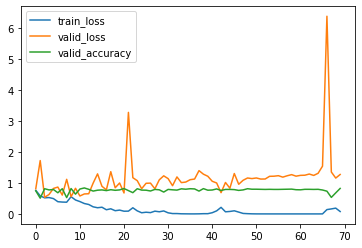

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7615026899327164
TEST
loss: 5.751332676599896
accuracy: 0.6603174603174603
******************
epoch: 1
Train
0.5791650864697336
TEST
loss: 0.5260430676596505
accuracy: 0.8158730158730159
******************
epoch: 2
Train
0.5131046494219017
TEST
loss: 0.5451144742587256
accuracy: 0.8063492063492064
******************
epoch: 3
Train
0.5394624317326746
TEST
loss: 1.1736115220993284
accuracy: 0.6984126984126984
******************
epoch: 4
Train
0.5216970506218145
TEST
loss: 3.7280580270858037
accuracy: 0.2857142857142857
******************
epoch: 5
Train
0.4955450148692294
TEST
loss: 0.8890682379404704
accuracy: 0.746031746031746
******************
epoch: 6
Train
0.3892953253104821
TEST
loss: 0.9475022864720178
accuracy: 0.7523809523809524
******************
epoch: 7
Train
0.3355456798960994
TEST
loss: 0.4894702619030362
accuracy: 0.819047619047619
******************
epoch: 8
Train
0.3349593086930094
TEST
loss: 0.5828240602735489
accuracy: 0.7

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8248730964467005


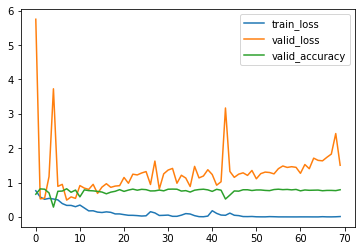

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8478034997952183
TEST
loss: 0.5831658701101939
accuracy: 0.7777777777777778
******************
epoch: 1
Train
0.6603644151267217
TEST
loss: 0.6480593367228432
accuracy: 0.7365079365079366
******************
epoch: 2
Train
0.5762909752353019
TEST
loss: 1.7911999588920957
accuracy: 0.7777777777777778
******************
epoch: 3
Train
0.5988206194448887
TEST
loss: 0.5197173379716419
accuracy: 0.8063492063492064
******************
epoch: 4
Train
0.5686170870913126
TEST
loss: 1.49903438772474
accuracy: 0.5365079365079365
******************
epoch: 5
Train
0.5587508701634274
TEST
loss: 0.5558088045271616
accuracy: 0.7936507936507936
******************
epoch: 6
Train
0.503158367324008
TEST
loss: 0.5601450781973581
accuracy: 0.7714285714285715
******************
epoch: 7
Train
0.5264195406645229
TEST
loss: 0.5953491614924536
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.4946064461049246
TEST
loss: 0.5467182819805448
accuracy: 0.8

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8807106598984772


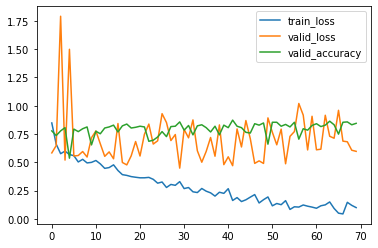

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.9502148905663949
TEST
loss: 3.546360224769229
accuracy: 0.30793650793650795
******************
epoch: 1
Train
0.7508020094692754
TEST
loss: 0.7304287794090453
accuracy: 0.7015873015873015
******************
epoch: 2
Train
0.673503477697433
TEST
loss: 0.6307884617457314
accuracy: 0.7841269841269841
******************
epoch: 3
Train
0.6852379344681883
TEST
loss: 0.6638162788890657
accuracy: 0.7777777777777778
******************
epoch: 4
Train
0.6612580974391759
TEST
loss: 0.6335471347210899
accuracy: 0.7746031746031746
******************
epoch: 5
Train
0.6476939333346838
TEST
loss: 0.7209432755197798
accuracy: 0.7587301587301587
******************
epoch: 6
Train
0.6314424856775237
TEST
loss: 0.6980248279041714
accuracy: 0.7238095238095238
******************
epoch: 7
Train
0.6212508146539389
TEST
loss: 27.64595484657893
accuracy: 0.6793650793650794
******************
epoch: 8
Train
0.6228780228765926
TEST
loss: 0.666239615470644
accuracy: 0.7

In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8147208121827412


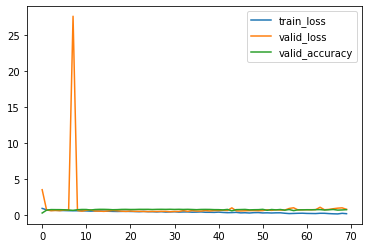

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.9311557222776132
TEST
loss: 1.6621163947241646
accuracy: 0.28253968253968254
******************
epoch: 1
Train
0.6996047069289743
TEST
loss: 1.0832135779517038
accuracy: 0.6
******************
epoch: 2
Train
0.6051864919442804
TEST
loss: 0.8851404931810167
accuracy: 0.6317460317460317
******************
epoch: 3
Train
0.658291100035403
TEST
loss: 3.541696435686142
accuracy: 0.726984126984127
******************
epoch: 4
Train
0.5913580537694517
TEST
loss: 1.200011444470239
accuracy: 0.5047619047619047
******************
epoch: 5
Train
0.5723892292207532
TEST
loss: 0.6936535784176417
accuracy: 0.7365079365079366
******************
epoch: 6
Train
0.5455581604061475
TEST
loss: 1.7709426770134578
accuracy: 0.46984126984126984
******************
epoch: 7
Train
0.527283228324272
TEST
loss: 0.627505250014956
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.5024613850025832
TEST
loss: 0.8092907394681658
accuracy: 0.7396825396825397


In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8045685279187818


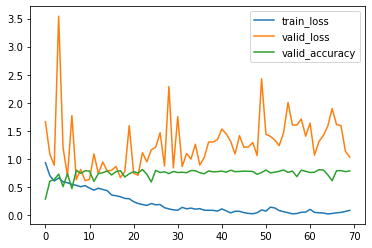

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7833704203722305
TEST
loss: 1.0506888702748314
accuracy: 0.7015873015873015
******************
epoch: 1
Train
0.5629668313421078
TEST
loss: 0.5781389770999787
accuracy: 0.7936507936507936
******************
epoch: 2
Train
0.49117905209233026
TEST
loss: 0.655196396793638
accuracy: 0.7746031746031746
******************
epoch: 3
Train
0.4839354847706529
TEST
loss: 0.7249025204825023
accuracy: 0.7936507936507936
******************
epoch: 4
Train
0.41961772561167987
TEST
loss: 0.6120735368085286
accuracy: 0.7904761904761904
******************
epoch: 5
Train
0.40200057552389157
TEST
loss: 0.7032040639529152
accuracy: 0.8063492063492064
******************
epoch: 6
Train
0.3847254712587316
TEST
loss: 1.1268587451132517
accuracy: 0.7936507936507936
******************
epoch: 7
Train
0.3701087783214306
TEST
loss: 0.6148500521977742
accuracy: 0.8222222222222222
******************
epoch: 8
Train
0.3390255813517203
TEST
loss: 0.9098310557622759
accuracy

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8096446700507615


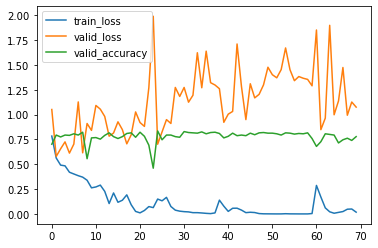

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.763977087992728
TEST
loss: 2.380818477887956
accuracy: 0.4984126984126984
******************
epoch: 1
Train
0.5895276292152496
TEST
loss: 0.7038248449090927
accuracy: 0.7841269841269841
******************
epoch: 2
Train
0.5431240238397248
TEST
loss: 0.5708757845182267
accuracy: 0.8031746031746032
******************
epoch: 3
Train
0.48559698741809065
TEST
loss: 0.954078031153906
accuracy: 0.6412698412698413
******************
epoch: 4
Train
0.4040205241362191
TEST
loss: 1.5764178357427083
accuracy: 0.7746031746031746
******************
epoch: 5
Train
0.4482610302372903
TEST
loss: 0.6499066451239207
accuracy: 0.6507936507936508
******************
epoch: 6
Train
0.3572474969010963
TEST
loss: 0.6867248888053591
accuracy: 0.7841269841269841
******************
epoch: 7
Train
0.3648679555646004
TEST
loss: 0.5112639810830828
accuracy: 0.8253968253968254
******************
epoch: 8
Train
0.32763145791812015
TEST
loss: 1.5483449977541728
accuracy: 0

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


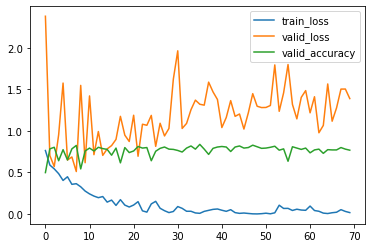

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8246846402609888
TEST
loss: 0.7790902718665108
accuracy: 0.7587301587301587
******************
epoch: 1
Train
0.636131174607917
TEST
loss: 1.00566817011152
accuracy: 0.580952380952381
******************
epoch: 2
Train
0.5657789356610053
TEST
loss: 0.5789274883648706
accuracy: 0.7968253968253968
******************
epoch: 3
Train
0.5839479763040095
TEST
loss: 0.9610799935128954
accuracy: 0.726984126984127
******************
epoch: 4
Train
0.5783953563479605
TEST
loss: 0.8134214265005929
accuracy: 0.6095238095238096
******************
epoch: 5
Train
0.5216266044650029
TEST
loss: 0.49148968373026164
accuracy: 0.8095238095238095
******************
epoch: 6
Train
0.4826870960693117
TEST
loss: 1.265616596691192
accuracy: 0.44761904761904764
******************
epoch: 7
Train
0.5117176148605498
TEST
loss: 0.6295716685908181
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.49193168249842284
TEST
loss: 0.5003192270558978
accuracy: 0.8

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8781725888324873


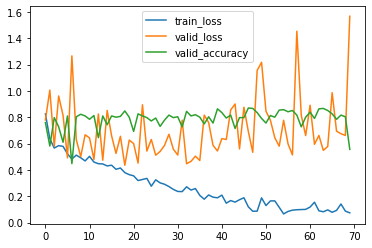

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.9211789474684251
TEST
loss: 2.0501681592729355
accuracy: 0.43174603174603177
******************
epoch: 1
Train
0.7507764213230991
TEST
loss: 0.7041512287798382
accuracy: 0.7555555555555555
******************
epoch: 2
Train
0.6692583229780387
TEST
loss: 0.6301000257333119
accuracy: 0.7936507936507936
******************
epoch: 3
Train
0.6708136999105252
TEST
loss: 0.6059788203428662
accuracy: 0.7968253968253968
******************
epoch: 4
Train
0.6550933731463904
TEST
loss: 0.6159448257514408
accuracy: 0.7873015873015873
******************
epoch: 5
Train
0.618742340845755
TEST
loss: 0.7050149463471912
accuracy: 0.7746031746031746
******************
epoch: 6
Train
0.6469732366259653
TEST
loss: 0.6350485632343897
accuracy: 0.7841269841269841
******************
epoch: 7
Train
0.6119176115044722
TEST
loss: 0.9701064665166158
accuracy: 0.7396825396825397
******************
epoch: 8
Train
0.5993229401452471
TEST
loss: 0.8046649749316866
accuracy: 

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8071065989847716


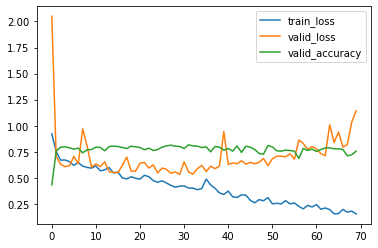

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7964584291502064
TEST
loss: 4.892696897567265
accuracy: 0.3873015873015873
******************
epoch: 1
Train
0.6446312863832433
TEST
loss: 0.5735841693386199
accuracy: 0.819047619047619
******************
epoch: 2
Train
0.5396988319441665
TEST
loss: 0.4967254877090454
accuracy: 0.8126984126984127
******************
epoch: 3
Train
0.5533702328055505
TEST
loss: 0.6895927938203963
accuracy: 0.7587301587301587
******************
epoch: 4
Train
0.5201069747199134
TEST
loss: 0.5173365061245268
accuracy: 0.8031746031746032
******************
epoch: 5
Train
0.5200474912728271
TEST
loss: 0.6712012816989232
accuracy: 0.7904761904761904
******************
epoch: 6
Train
0.48099074295534794
TEST
loss: 1.0628844486342537
accuracy: 0.5904761904761905
******************
epoch: 7
Train
0.49705489809499837
TEST
loss: 0.5489823868350378
accuracy: 0.7936507936507936
******************
epoch: 8
Train
0.4700491674439693
TEST
loss: 0.5581846380044544
accuracy: 

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8807106598984772


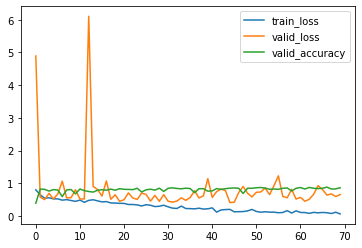

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0067042039915908
TEST
loss: 0.7809931908335005
accuracy: 0.6793650793650794
******************
epoch: 1
Train
0.8351670629074879
TEST
loss: 0.6796391736893427
accuracy: 0.7682539682539683
******************
epoch: 2
Train
0.7193415697791257
TEST
loss: 0.6209134893757956
accuracy: 0.780952380952381
******************
epoch: 3
Train
0.6775374884544809
TEST
loss: 0.6774789723138961
accuracy: 0.7333333333333333
******************
epoch: 4
Train
0.6285340315865751
TEST
loss: 0.5793726960817973
accuracy: 0.7841269841269841
******************
epoch: 5
Train
0.6044664293930018
TEST
loss: 0.6797491387715415
accuracy: 0.7619047619047619
******************
epoch: 6
Train
0.5951791239504401
TEST
loss: 0.5984995239310794
accuracy: 0.7682539682539683
******************
epoch: 7
Train
0.5912512282798743
TEST
loss: 0.5505390512564826
accuracy: 0.8
******************
epoch: 8
Train
0.553574922268972
TEST
loss: 0.6441441061950866
accuracy: 0.765079365079365

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


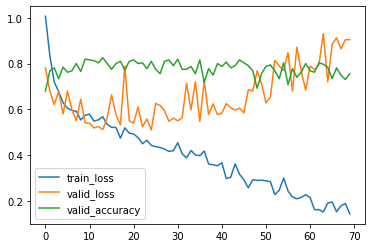

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7683099477039244
TEST
loss: 0.8973100271489886
accuracy: 0.7619047619047619
******************
epoch: 1
Train
0.5849420761332993
TEST
loss: 0.5721688864723085
accuracy: 0.8031746031746032
******************
epoch: 2
Train
0.5059126624519433
TEST
loss: 0.5911148446892935
accuracy: 0.780952380952381
******************
epoch: 3
Train
0.5099568796404019
TEST
loss: 0.5105491472615136
accuracy: 0.8063492063492064
******************
epoch: 4
Train
0.5049858308671674
TEST
loss: 0.5778865053540184
accuracy: 0.8
******************
epoch: 5
Train
0.5066431869676513
TEST
loss: 0.624841015206443
accuracy: 0.7904761904761904
******************
epoch: 6
Train
0.45687185742724407
TEST
loss: 0.6367564185271187
accuracy: 0.8126984126984127
******************
epoch: 7
Train
0.4295612557053661
TEST
loss: 0.624859963523017
accuracy: 0.7619047619047619
******************
epoch: 8
Train
0.4508718952974504
TEST
loss: 0.5937563220186839
accuracy: 0.796825396825396

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8071065989847716


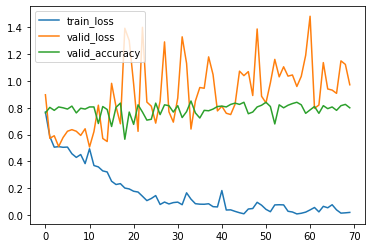

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8109692965262082
TEST
loss: 0.748014879983569
accuracy: 0.746031746031746
******************
epoch: 1
Train
0.6009337553625735
TEST
loss: 0.8006895744611346
accuracy: 0.6952380952380952
******************
epoch: 2
Train
0.55135087016748
TEST
loss: 0.587554066900223
accuracy: 0.8063492063492064
******************
epoch: 3
Train
0.5236805943007314
TEST
loss: 1.4254126764479138
accuracy: 0.5111111111111111
******************
epoch: 4
Train
0.5448819432966855
TEST
loss: 0.6205101353781564
accuracy: 0.7746031746031746
******************
epoch: 5
Train
0.48288584233655923
TEST
loss: 0.5468578179677327
accuracy: 0.8
******************
epoch: 6
Train
0.38987847596904035
TEST
loss: 0.5880236213169401
accuracy: 0.780952380952381
******************
epoch: 7
Train
0.3675993549340864
TEST
loss: 1.007623921500312
accuracy: 0.6349206349206349
******************
epoch: 8
Train
0.3866934175407063
TEST
loss: 2.304843432562692
accuracy: 0.2253968253968254
**

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


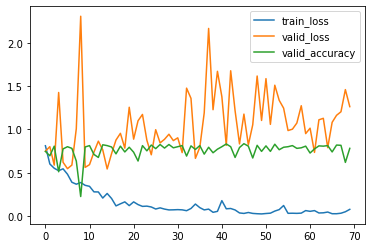

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8204402557623774
TEST
loss: 0.7586544065248398
accuracy: 0.7365079365079366
******************
epoch: 1
Train
0.6149652159999911
TEST
loss: 0.6809866877775343
accuracy: 0.7936507936507936
******************
epoch: 2
Train
0.5182342784474822
TEST
loss: 0.4764311055342356
accuracy: 0.8253968253968254
******************
epoch: 3
Train
0.5026771452239432
TEST
loss: 0.6904863481483762
accuracy: 0.7555555555555555
******************
epoch: 4
Train
0.4772730329332132
TEST
loss: 0.6203697892408523
accuracy: 0.7746031746031746
******************
epoch: 5
Train
0.46158415301628203
TEST
loss: 0.5041977013387378
accuracy: 0.8095238095238095
******************
epoch: 6
Train
0.387392638906588
TEST
loss: 0.6752546649130564
accuracy: 0.692063492063492
******************
epoch: 7
Train
0.3418031934947604
TEST
loss: 0.9358030337189871
accuracy: 0.8126984126984127
******************
epoch: 8
Train
0.3614351384406813
TEST
loss: 1.1385086050109259
accuracy: 0

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


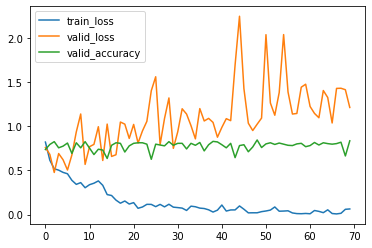

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8175209387604256
TEST
loss: 1.0670785249225676
accuracy: 0.5047619047619047
******************
epoch: 1
Train
0.617320556362249
TEST
loss: 1.2245003632136753
accuracy: 0.44126984126984126
******************
epoch: 2
Train
0.5693280369493108
TEST
loss: 1.3733951292340718
accuracy: 0.546031746031746
******************
epoch: 3
Train
0.5164409788758912
TEST
loss: 0.6561136879618206
accuracy: 0.7682539682539683
******************
epoch: 4
Train
0.49625124689413497
TEST
loss: 0.6850539730654822
accuracy: 0.7206349206349206
******************
epoch: 5
Train
0.4739643596201496
TEST
loss: 0.7953100700227042
accuracy: 0.765079365079365
******************
epoch: 6
Train
0.39960167941069963
TEST
loss: 0.6603656483074976
accuracy: 0.8
******************
epoch: 7
Train
0.4329671432945442
TEST
loss: 1.1299975849333264
accuracy: 0.6761904761904762
******************
epoch: 8
Train
0.3595887920134971
TEST
loss: 0.7996027766712128
accuracy: 0.7904761904761

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


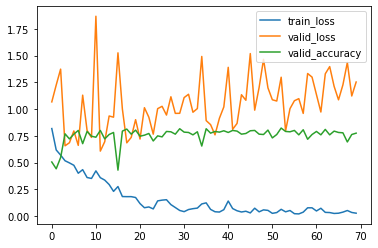

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7788449023052091
TEST
loss: 3.013755036157275
accuracy: 0.473015873015873
******************
epoch: 1
Train
0.6424021803499499
TEST
loss: 0.7068687218522268
accuracy: 0.7365079365079366
******************
epoch: 2
Train
0.5748271590854744
TEST
loss: 0.5019887374507056
accuracy: 0.819047619047619
******************
epoch: 3
Train
0.5687462432787852
TEST
loss: 0.6738923137150113
accuracy: 0.7301587301587301
******************
epoch: 4
Train
0.5431999668561815
TEST
loss: 0.8791826452527728
accuracy: 0.6
******************
epoch: 5
Train
0.5068064423853486
TEST
loss: 0.6582253579109434
accuracy: 0.780952380952381
******************
epoch: 6
Train
0.39831218383821637
TEST
loss: 0.992749571989453
accuracy: 0.7968253968253968
******************
epoch: 7
Train
0.43466511986575684
TEST
loss: 0.6642913818359375
accuracy: 0.726984126984127
******************
epoch: 8
Train
0.39563452126347326
TEST
loss: 0.9805302281228323
accuracy: 0.5841269841269842

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8096446700507615


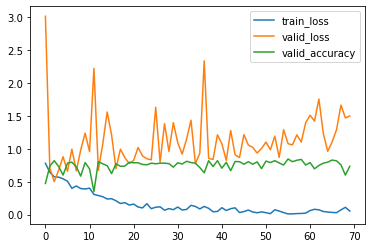

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8693803275171209
TEST
loss: 0.6561517914136251
accuracy: 0.7777777777777778
******************
epoch: 1
Train
0.6553703647837741
TEST
loss: 0.6108458733747876
accuracy: 0.8
******************
epoch: 2
Train
0.5848228952257855
TEST
loss: 0.6860707740935068
accuracy: 0.726984126984127
******************
epoch: 3
Train
0.5457522925448096
TEST
loss: 0.6374578560155536
accuracy: 0.7904761904761904
******************
epoch: 4
Train
0.5257560366718801
TEST
loss: 0.5909717915550111
accuracy: 0.7682539682539683
******************
epoch: 5
Train
0.5139793243741497
TEST
loss: 0.6234380396585616
accuracy: 0.7492063492063492
******************
epoch: 6
Train
0.45375858501747923
TEST
loss: 0.5571312081246149
accuracy: 0.8031746031746032
******************
epoch: 7
Train
0.4099943901074132
TEST
loss: 0.8853871676656935
accuracy: 0.6888888888888889
******************
epoch: 8
Train
0.4051397854463745
TEST
loss: 0.6839403527123588
accuracy: 0.7777777777777

In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8248730964467005


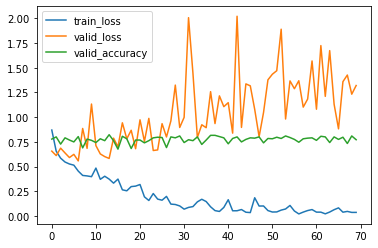

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()